In [1]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document as LangchainDocument
from PyPDF2 import PdfReader
import os
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
from ragatouille import RAGPretrainedModel

from transformers import AutoTokenizer

/home/javierj/miniconda3/envs/gatherer-sage/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Reading Documents

In [2]:
def get_pdf_content(documents):
    raw_texts = []

    for document in documents:
        raw_text = ""
        pdf_reader = PdfReader(document)
        for page in pdf_reader.pages:
            raw_text += page.extract_text()
        
        raw_texts.append(raw_text)

    return raw_texts

def get_langchain_docs(documents):
    return [LangchainDocument(doc) for doc in get_pdf_content(documents)]

docs_folder = "data/rules/"
doc_paths = [docs_folder + f for f in os.listdir(docs_folder)]
langchaing_docs = get_langchain_docs(doc_paths)

## 2. Computing Optimal Chunk Size

/home/javierj/miniconda3/envs/gatherer-sage/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model's maximum sequence length: 512


100%|██████████| 1362/1362 [00:00<00:00, 4620.99it/s]


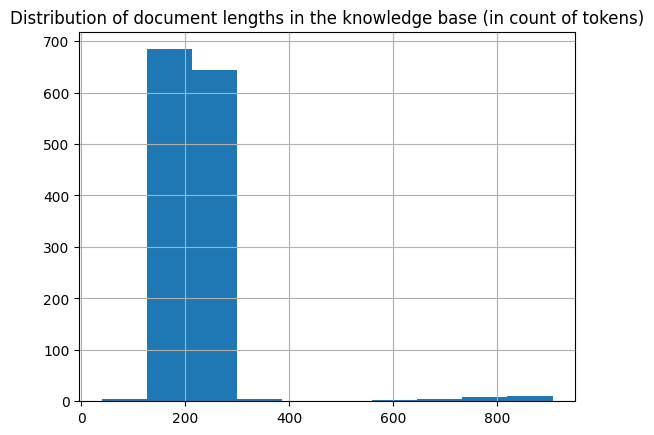

In [3]:
EMBEDDING_MODEL = "thenlper/gte-large"

markdown_separators = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # The number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=markdown_separators,
)

docs_processed = []
for doc in langchaing_docs:
    docs_processed += text_splitter.split_documents([doc])

print(f"Model's maximum sequence length: {SentenceTransformer(EMBEDDING_MODEL).max_seq_length}")

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

## 3. Creating Vector Database

In [4]:
def split_documents(
    knowledge_base,
    tokenizer_name,
    chunk_size: int=512
):
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    markdown_separators = [
        "\n#{1,6} ",
        "```\n",
        "\n\\*\\*\\*+\n",
        "\n---+\n",
        "\n___+\n",
        "\n\n",
        "\n",
        " ",
        "",
    ]
    
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=markdown_separators,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique

docs_processed = split_documents(
    langchaing_docs,
    EMBEDDING_MODEL,
)

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

vector_database = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

/home/javierj/miniconda3/envs/gatherer-sage/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## 4. Using RAG

### 4.1. Model Definition

In [5]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

READER_MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

`low_cpu_mem_usage` was None, now set to True since model is quantized.
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
question = "Can I tap permenents when ever I like. Except of corse if it was already taped or had summoning sickness."
READER_LLM(question)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[{'generated_text': ' That would be a problem.\nI think you\'re misunderstanding the concept of permanents and tapping. Tapping is not a way to play with your permanents whenever you want, but rather a way to use their abilities in a specific turn.\n\nWhen you tap a permanent, you\'re essentially "borrowing" its ability for that one turn. You can\'t just tap a permanent whenever you want, because you need to have a specific reason to do so (like playing a spell or activating an ability). And as you mentioned, there are some exceptions, like permanents that are already tapped or those with summoning sickness.\n\nFor example, let\'s say you have a creature with a 2/2 body and a tap ability that says "T: Add 1R". If you want to add 1 red mana to your pool during your main phase, you could tap that creature to activate its ability. But you couldn\'t just tap it randomly, because you\'d need to have a specific reason to do so.\n\nDoes that make sense? Let me know if you have any more questi

### 4.2. Prompt Template

In [7]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive and concise answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the rule when relevant.
If the answer cannot be deduced from the context, do not give an answer.
The questions are related with Magic The Gathering card game.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]

prompt_template = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(prompt_template)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.
The questions are related with Magic The Gathering card game.<|eot_id|><|start_header_id|>user<|end_header_id|>

Context:
{context}
---
Now here is the question you need to answer.

Question: {question}<|eot_id|><|start_header_id|>assistant<|end_header_id|>




### 4.3. Test

In [10]:
reranker = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

def answer_with_rag(
    question: str,
    llm,
    vector_db,
    prompt_template,
    reranker = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
):
    relevant_docs = vector_db.similarity_search(query=question, k=num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in relevant_docs]  # Keep only the text

    if reranker:
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    context = "\nExtracted documents:\n"
    context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)])

    final_prompt = prompt_template.format(question=question, context=context)

    answer = llm(final_prompt)[0]["generated_text"]

    return answer

print("Q: ",question)
print("A: ",answer_with_rag(
    question,
    llm=READER_LLM,
    vector_db=vector_database,
    prompt_template=prompt_template,
    reranker=reranker
))


Q:  Can I tap permenents when ever I like. Except of corse if it was already taped or had summoning sickness.


100%|██████████| 1/1 [00:00<00:00, 22.96it/s]
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


A:  According to the provided documents, specifically rule 302.6, "A creature's activated ability with the tap symbol or the untap symbol in its activation cost can't be activated unless the creature has been under its controller's control continuously since their most recent turn began."

This means that you cannot tap a permanent (which is equivalent to activating its mana ability) at any time you like. You can only tap a permanent if it has been under your control continuously since your last turn began.

Additionally, according to rule 602.5a, "A creature's activated ability with the tap symbol ({T}) or the untap symbol ({Q}) in its activation cost can't be activated unless the creature has been under its controller's control since the start of their most recent turn." This rule applies to all creatures, including those without summoning sickness.

So, to summarize, you can tap permanents only when the conditions mentioned above are met, i.e., when the permanent has been under your

In [11]:
q1 = "If my oponent play a sorcery as an instant what happend?"

print("Q: ",q1)
print("A: ",answer_with_rag(
    q1,
    llm=READER_LLM,
    vector_db=vector_database,
    prompt_template=prompt_template,
    reranker=reranker
))


Q:  If my oponent play a sorcery as an instant what happend?


100%|██████████| 1/1 [00:00<00:00, 22.39it/s]
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


A:  According to Rule 307.5, "If a spell, ability, or effect states that a player can do something only 'any time they could cast a sorcery' or 'only as a sorcery,' it means only that the player must have priority, it must be during the main phase of their turn, and the stack must be empty. The player doesn't need to have a sorcery card they could cast."

In this case, your opponent is playing a sorcery as an instant, which means they are following the timing rules for casting an instant spell. According to Rule 304.1, "A player who has priority may cast an instant card from their hand. Casting an instant as a spell uses the stack." So, the sorcery is being cast as an instant, using the stack.

As a result, the sorcery will resolve as normal, and its effects will be applied.
